In [1]:
import ast
import gc
import glob
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import sys
from functools import partial

sys.path.append("/app/_data/MONAI")
import monai
from monai.data import NibabelWriter

Extension horovod.torch has not been built: /usr/local/lib/python3.8/dist-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


In [2]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)

In [3]:
df = df.sort_values("id").reset_index(drop=True)

In [4]:
all_data = []
for case_day, group_df in df.groupby(["case", "day"]):
    group_df = group_df.reset_index(drop=True)
    imgs, labels = [], []
    for ix in group_df.index:
        imgs.append(group_df.loc[ix, "img_npy"])
        labels.append(group_df.loc[ix, "mask_npy"])
    all_data.append({"image": imgs, "label": labels})

In [5]:
path = "/app/_data/vol_data/"
os.makedirs(path, exist_ok=True)
data_info = []
for data in tqdm(all_data):
    name = "_".join(data["image"][0].split("/")[-1].split("_")[:2])
    imgs = np.stack([np.load(path) for path in data["image"]], axis=-1).astype("int16")
    masks = np.stack(
        [np.load(path).transpose(2, 0, 1) for path in data["label"]], axis=-1
    ).astype("uint8")
    writer = NibabelWriter()
    writer.set_data_array(imgs, channel_dim=None)
    writer.set_metadata({"dtype": np.int16})
    writer.write(os.path.join(path, f"{name}_image.nii.gz"))

    writer = NibabelWriter()
    writer.set_data_array(masks, channel_dim=0)
    writer.set_metadata({"dtype": np.uint8})
    writer.write(os.path.join(path, f"{name}_mask.nii.gz"))
    data_info.append(
        {
            "id": name,
            "fold": df[df["id"].str.contains(name)]["fold"].values[0].astype("uint8"),
            "image_path": os.path.join(path, f"{name}_image.nii.gz"),
            "mask_path": os.path.join(path, f"{name}_mask.nii.gz"),
        }
    )

100% 272/272 [10:24<00:00,  2.30s/it]


In [6]:
data_3d_info = pd.DataFrame(data_info)
data_3d_info

,id,fold,image_path,mask_path
0,case101_day20,1,/app/_data/vol_data/case101_day20_image.nii.gz,/app/_data/vol_data/case101_day20_mask.nii.gz
1,case101_day22,1,/app/_data/vol_data/case101_day22_image.nii.gz,/app/_data/vol_data/case101_day22_mask.nii.gz
2,case101_day26,1,/app/_data/vol_data/case101_day26_image.nii.gz,/app/_data/vol_data/case101_day26_mask.nii.gz
3,case101_day32,1,/app/_data/vol_data/case101_day32_image.nii.gz,/app/_data/vol_data/case101_day32_mask.nii.gz
4,case102_day0,4,/app/_data/vol_data/case102_day0_image.nii.gz,/app/_data/vol_data/case102_day0_mask.nii.gz
...,...,...,...,...
267,case90_day0,3,/app/_data/vol_data/case90_day0_image.nii.gz,/app/_data/vol_data/case90_day0_mask.nii.gz
268,case90_day22,3,/app/_data/vol_data/case90_day22_image.nii.gz,/app/_data/vol_data/case90_day22_mask.nii.gz
269,case90_day29,3,/app/_data/vol_data/case90_day29_image.nii.gz,/app/_data/vol_data/case90_day29_mask.nii.gz
270,case91_day0,2,/app/_data/vol_data/case91_day0_image.nii.gz,/app/_data/vol_data/case91_day0_mask.nii.gz


In [7]:
data_3d_info.to_csv("/app/data_3d_info.csv", index=False)

In [8]:
FOLD = 1
train_df = data_3d_info[data_3d_info["fold"] != FOLD]
val_df = data_3d_info[data_3d_info["fold"] == FOLD]
train = [
    {"image": x, "label": y} for x, y in train_df[["image_path", "mask_path"]].values
]
val = [{"image": x, "label": y} for x, y in val_df[["image_path", "mask_path"]].values]

In [9]:
IMG_SIZE = (224,224,80)
h, w, d = IMG_SIZE

train_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=["image", "label"],),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
                keys="label", indices=[3, 0, 1, 2]
            ),  # h, w, d, c to c, h, w, d
        monai.transforms.RandSpatialCropd(
            keys=("image", "label"),
            roi_size=IMG_SIZE,
            random_size=False,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        monai.transforms.RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        monai.transforms.RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        monai.transforms.RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        monai.transforms.OneOf(
            [
                monai.transforms.RandGridDistortiond(
                    keys=["image", "label"],
                    prob=0.2,
                    distort_limit=(-0.05, 0.05),
                    mode="nearest",
                    padding_mode="zeros",
                ),
                monai.transforms.RandAffined(
                    keys=["image", "label"],
                    prob=0.2,
                    rotate_range=np.pi / 12,
                    translate_range=(h * 0.0625, h * 0.0625),
                    scale_range=(0.1, 0.1),
                    mode="nearest",
                    padding_mode="zeros",
                ),
            ],
        ),
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        # monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=["image", "label"],),
        monai.transforms.AddChanneld(keys="image"),
        monai.transforms.Transposed(
                keys="label", indices=[3, 0, 1, 2]
            ),  # h, w, d, c to c, h, w, d
        monai.transforms.Lambdad(
            keys="image", func=lambda x: x / x.max()
        ),  # normalize to [0, 1] range
        # monai.transforms.EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [10]:
train_ds = monai.data.CacheDataset(
    data=train,
    transform=train_transforms,
    cache_num=2,
    cache_rate=1.0,
    num_workers=0,
)
val_ds = monai.data.CacheDataset(
    data=val,
    transform=val_transforms,
    cache_num=2,
    cache_rate=1.0,
    num_workers=0,
)

Loading dataset: 100% 2/2 [00:01<00:00,  1.04it/s]
Loading dataset: 100% 2/2 [00:01<00:00,  1.23it/s]


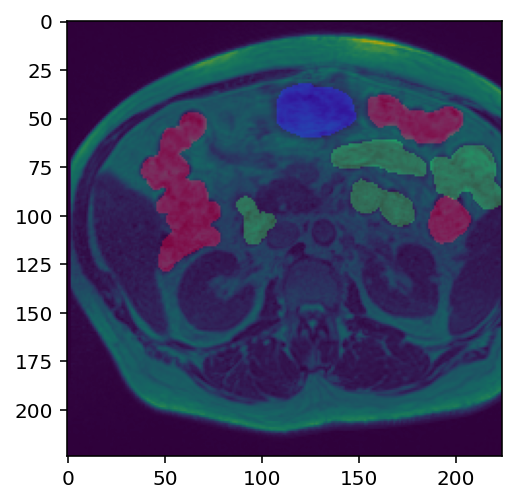

In [11]:
ix = 2
img = train_ds[ix]
i = 49
plt.imshow(img["image"].numpy()[0, :, :, i])
plt.imshow(img["label"].numpy()[:, :, :, i].transpose(1, 2, 0), alpha=0.3)
plt.show();